In [2]:
#KS200, 기본 코드, overfitting, Train_test_split, cv = TimeSeriesSplit

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import confusion_matrix
import joblib

# 데이터 불러오기 및 전처리
model_data = pd.read_csv('real_dataset/ks200.csv', encoding='utf-8')

# Label Encoding
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
model_data['레이블'] = encoder.fit_transform(model_data['레이블'])

# 날짜 처리 및 정렬
model_data['날짜'] = pd.to_datetime(model_data['날짜'])
model_data.set_index('날짜', inplace=True)
model_data.sort_index(inplace=True)

# 특성과 레이블 분리
X = model_data.drop(columns=['레이블'])
y = model_data['레이블']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 모델 초기화 및 하이퍼파라미터 그리드 정의
rnd_clf = RandomForestClassifier(n_estimators=100, n_jobs=1, random_state=42)
param_dist_rf = {
    'n_estimators': [50, 100, 500],
    'max_leaf_nodes': [20, 30, 40, 50],
    'max_features': [1, 2, 3],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 하이퍼파라미터 튜닝
time_split_cv = TimeSeriesSplit(n_splits=10)
rnd_search = RandomizedSearchCV(rnd_clf, param_dist_rf, cv=time_split_cv, random_state =42)
rnd_search.fit(X_train, y_train)

# 최적 모델 선택 및 훈련
best_clf = rnd_search.best_estimator_
best_clf.fit(X_train, y_train)

# 모델 평가
train_score = best_clf.score(X_train, y_train)
test_score = best_clf.score(X_test, y_test)

# 10-fold cross-validation의 정확도 계산
cv_scores = cross_val_score(best_clf, X_train, y_train, cv=time_split_cv, scoring='accuracy')
cv_mean_score = cv_scores.mean()

# label encoding된 값 찾기
up = encoder.transform(['up'])[0]
neutral = encoder.transform(['neutral'])[0]
down = encoder.transform(['down'])[0]

# 혼동 행렬 확인
y_test_pred = best_clf.predict(X_test)
cm_test = confusion_matrix(y_test, y_test_pred, labels=[up, neutral, down])
y_all_pred = best_clf.predict(X)
cm_all = confusion_matrix(y, y_all_pred, labels=[up, neutral, down])


# 특성 중요도 확인
feature_importance = list(zip(X_train.columns, best_clf.feature_importances_))

# 모델 저장
joblib.dump(best_clf, "separation22.pkl")

# 결과 출력

# 결과를 출력합니다.
print(f"{rnd_search.best_params_}\n")
print("<10-fold cross-validation>")
print("accuracy score mean: ", cv_mean_score)
print("\n<AI model: machine learning done >")
print("accuracy_score of train data(0.8 of sample): ", train_score)
print("accuracy_score of test data(0.2 of sample): ", test_score)
print("\n<Confusion matrix>")
print("(of test)")
print("up", "neutral", "down")
print(cm_test)
print("(of all)")
print("up", "neutral", "down")
print(cm_all)
# <Feature importance>를 내림차순으로 정렬하여 출력
print("\n<Feature importance>")
sorted_feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
for name, score in sorted_feature_importance:
    print(name, ": ", score)

print("\n< AI model: save >")

{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_leaf_nodes': 50, 'max_features': 3, 'max_depth': 15}

<10-fold cross-validation>
accuracy score mean:  0.8146226415094342

<AI model: machine learning done >
accuracy_score of train data(0.8 of sample):  0.8721129170230967
accuracy_score of test data(0.2 of sample):  0.8427350427350427

<Confusion matrix>
(of test)
up neutral down
[[151  16   2]
 [ 19  99  26]
 [  5  24 243]]
(of all)
up neutral down
[[ 760   77   10]
 [  94  497  128]
 [  15   67 1275]]

<Feature importance>
PBR :  0.10580755694353722
PER :  0.10540610954454843
WTI :  0.0928245797277971
VIX :  0.07501860179976219
통화량 :  0.07357399298804475
수입금액지수 :  0.06966526035063397
경제심리지수 :  0.06795335132640001
환율 :  0.0604525300436016
수출금액지수 :  0.05935444156083608
소비자물가지수 :  0.056108142030278835
경기종합지수 :  0.04996020620724781
미국경제성장률 :  0.04106926557876167
고용률 :  0.040181843323872445
실업률 :  0.03722253840031011
기준금리 :  0.03307059133952391
한국경제성장률 :  0.0323309

In [3]:
#KS200, 기술적 지표 추가한 코드, overfitting, Train_test_split, cv = TimeSeriesSplit

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import confusion_matrix
import joblib

# 데이터 불러오기 및 전처리
model_data = pd.read_csv('merged_data.csv', encoding='utf-8')

# Label Encoding
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
model_data['레이블'] = encoder.fit_transform(model_data['레이블'])

# 날짜 처리 및 정렬
model_data['날짜'] = pd.to_datetime(model_data['날짜'])
model_data.set_index('날짜', inplace=True)
model_data.sort_index(inplace=True)

# 특성과 레이블 분리
X = model_data.drop(columns=['레이블'])
y = model_data['레이블']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 모델 초기화 및 하이퍼파라미터 그리드 정의
rnd_clf = RandomForestClassifier(n_estimators=100, n_jobs=1, random_state=42)
param_dist_rf = {
    'n_estimators': [50, 100, 500],
    'max_leaf_nodes': [20, 30, 40, 50],
    'max_features': [1, 2, 3],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 하이퍼파라미터 튜닝
time_split_cv = TimeSeriesSplit(n_splits=10)
rnd_search = RandomizedSearchCV(rnd_clf, param_dist_rf, cv=time_split_cv, random_state =42)
rnd_search.fit(X_train, y_train)

# 최적 모델 선택 및 훈련
best_clf = rnd_search.best_estimator_
best_clf.fit(X_train, y_train)

# 모델 평가
train_score = best_clf.score(X_train, y_train)
test_score = best_clf.score(X_test, y_test)

# 10-fold cross-validation의 정확도 계산
cv_scores = cross_val_score(best_clf, X_train, y_train, cv=time_split_cv, scoring='accuracy')
cv_mean_score = cv_scores.mean()

# label encoding된 값 찾기
up = encoder.transform(['up'])[0]
neutral = encoder.transform(['neutral'])[0]
down = encoder.transform(['down'])[0]

# 혼동 행렬 확인
y_test_pred = best_clf.predict(X_test)
cm_test = confusion_matrix(y_test, y_test_pred, labels=[up, neutral, down])
y_all_pred = best_clf.predict(X)
cm_all = confusion_matrix(y, y_all_pred, labels=[up, neutral, down])


# 특성 중요도 확인
feature_importance = list(zip(X_train.columns, best_clf.feature_importances_))

# 모델 저장
joblib.dump(best_clf, "separation111.pkl")

# 결과 출력

# 결과를 출력합니다.
print(f"{rnd_search.best_params_}\n")
print("<10-fold cross-validation>")
print("accuracy score mean: ", cv_mean_score)
print("\n<AI model: machine learning done >")
print("accuracy_score of train data(0.8 of sample): ", train_score)
print("accuracy_score of test data(0.2 of sample): ", test_score)
print("\n<Confusion matrix>")
print("(of test)")
print("up", "neutral", "down")
print(cm_test)
print("(of all)")
print("up", "neutral", "down")
print(cm_all)
# <Feature importance>를 내림차순으로 정렬하여 출력
print("\n<Feature importance>")
sorted_feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
for name, score in sorted_feature_importance:
    print(name, ": ", score)

print("\n< AI model: save >")

{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_leaf_nodes': 50, 'max_features': 3, 'max_depth': 10}

<10-fold cross-validation>
accuracy score mean:  0.8308139534883721

<AI model: machine learning done >
accuracy_score of train data(0.8 of sample):  0.9047368421052632
accuracy_score of test data(0.2 of sample):  0.8547368421052631

<Confusion matrix>
(of test)
up neutral down
[[132  12   0]
 [ 11  79  30]
 [  3  13 195]]
(of all)
up neutral down
[[ 677   41    2]
 [  52  448  100]
 [   8   47 1000]]

<Feature importance>
MACD :  0.11128771871777035
WTI :  0.07907062324557065
PBR :  0.06373303116294625
경제심리지수 :  0.06258461394669514
PER :  0.05751509409231622
통화량 :  0.055718628600959275
고용률 :  0.05529784575164777
수입금액지수 :  0.047437509614284855
소비자물가지수 :  0.045489406434636066
수출금액지수 :  0.04306022974417183
OBV :  0.04255786234013742
환율 :  0.03791227469119112
ATR :  0.034204742151773646
VIX :  0.03312163260177795
기준금리 :  0.03261255954780107
경기종합지수 :  0.0323812279

In [5]:
#KS200 - finance, 기술적 지표 추가한 코드, overfitting, Train_test_split, cv = TimeSeriesSplit

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import confusion_matrix
import joblib

# 데이터 불러오기 및 전처리
model_data = pd.read_csv('merged_data/merged_data_finance.csv', encoding='utf-8')

# Label Encoding
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
model_data['레이블'] = encoder.fit_transform(model_data['레이블'])

# 날짜 처리 및 정렬
model_data['날짜'] = pd.to_datetime(model_data['날짜'])
model_data.set_index('날짜', inplace=True)
model_data.sort_index(inplace=True)

# 특성과 레이블 분리
X = model_data.drop(columns=['레이블'])
y = model_data['레이블']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 모델 초기화 및 하이퍼파라미터 그리드 정의
rnd_clf = RandomForestClassifier(n_estimators=100, n_jobs=1, random_state=42)
param_dist_rf = {
    'n_estimators': [50, 100, 500],
    'max_leaf_nodes': [20, 30, 40, 50],
    'max_features': [1, 2, 3],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 하이퍼파라미터 튜닝
time_split_cv = TimeSeriesSplit(n_splits=10)
rnd_search = RandomizedSearchCV(rnd_clf, param_dist_rf, cv=time_split_cv, random_state =42)
rnd_search.fit(X_train, y_train)

# 최적 모델 선택 및 훈련
best_clf = rnd_search.best_estimator_
best_clf.fit(X_train, y_train)

# 모델 평가
train_score = best_clf.score(X_train, y_train)
test_score = best_clf.score(X_test, y_test)

# 10-fold cross-validation의 정확도 계산
cv_scores = cross_val_score(best_clf, X_train, y_train, cv=time_split_cv, scoring='accuracy')
cv_mean_score = cv_scores.mean()

# label encoding된 값 찾기
up = encoder.transform(['up'])[0]
neutral = encoder.transform(['neutral'])[0]
down = encoder.transform(['down'])[0]

# 혼동 행렬 확인
y_test_pred = best_clf.predict(X_test)
cm_test = confusion_matrix(y_test, y_test_pred, labels=[up, neutral, down])
y_all_pred = best_clf.predict(X)
cm_all = confusion_matrix(y, y_all_pred, labels=[up, neutral, down])


# 특성 중요도 확인
feature_importance = list(zip(X_train.columns, best_clf.feature_importances_))

# 모델 저장
joblib.dump(best_clf, "separation111.pkl")

# 결과 출력

# 결과를 출력합니다.
print(f"{rnd_search.best_params_}\n")
print("<10-fold cross-validation>")
print("accuracy score mean: ", cv_mean_score)
print("\n<AI model: machine learning done >")
print("accuracy_score of train data(0.8 of sample): ", train_score)
print("accuracy_score of test data(0.2 of sample): ", test_score)
print("\n<Confusion matrix>")
print("(of test)")
print("up", "neutral", "down")
print(cm_test)
print("(of all)")
print("up", "neutral", "down")
print(cm_all)
# <Feature importance>를 내림차순으로 정렬하여 출력
print("\n<Feature importance>")
sorted_feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
for name, score in sorted_feature_importance:
    print(name, ": ", score)

print("\n< AI model: save >")

{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_leaf_nodes': 50, 'max_features': 3, 'max_depth': 10}

<10-fold cross-validation>
accuracy score mean:  0.8023255813953488

<AI model: machine learning done >
accuracy_score of train data(0.8 of sample):  0.8942105263157895
accuracy_score of test data(0.2 of sample):  0.8336842105263158

<Confusion matrix>
(of test)
up neutral down
[[122  18   4]
 [ 10  79  31]
 [  4  12 195]]
(of all)
up neutral down
[[659  54   7]
 [ 62 443  95]
 [ 14  48 993]]

<Feature importance>
WTI :  0.08624214881570527
OBV :  0.0673225970882731
경제심리지수 :  0.06722596882633594
MACD :  0.06573186766092191
통화량 :  0.0647921875885046
고용률 :  0.05811028916014381
소비자물가지수 :  0.05297906980422161
수입금액지수 :  0.047605510952755614
환율 :  0.04732054318879753
수출금액지수 :  0.04685113948549823
PBR :  0.04302941924684795
PER :  0.040243789653483276
기준금리 :  0.03889843836267624
VIX :  0.03694117300535243
경기종합지수 :  0.03626241240501627
ADX :  0.03478958320998619
실업률 :

In [1]:
#KS200 - finance, 기술적 지표 추가한 코드, 스케일링 O, Train_test_split 적용, cv = time_split_cv

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import joblib
from sklearn.preprocessing import LabelEncoder

# 데이터 불러오기 및 전처리
model_data = pd.read_csv('merged_data/merged_data_finance.csv', encoding='utf-8')

# Label Encoding
encoder = LabelEncoder()
model_data['레이블'] = encoder.fit_transform(model_data['레이블'])

# 날짜 처리 및 정렬
model_data['날짜'] = pd.to_datetime(model_data['날짜'])
model_data.set_index('날짜', inplace=True)
model_data.sort_index(inplace=True)

# 특성과 레이블 분리
X = model_data.drop(columns=['레이블'])
y = model_data['레이블']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 모델 초기화 및 하이퍼파라미터 그리드 정의
rnd_clf = RandomForestClassifier(n_jobs=1, random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 500],
    'max_leaf_nodes': [20, 30, 40, 50],
    'max_features': [1, 2, 3],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 하이퍼파라미터 튜닝
time_split_cv = TimeSeriesSplit(n_splits=10)
grid_search = GridSearchCV(rnd_clf, param_grid_rf, cv=time_split_cv, scoring='accuracy')
grid_search.fit(X_train, y_train)

# 최적 모델 선택 및 훈련
best_clf = grid_search.best_estimator_
best_clf.fit(X_train, y_train)

# 모델 평가
train_score = best_clf.score(X_train, y_train)
test_score = best_clf.score(X_test, y_test)

# 혼동 행렬 확인
y_test_pred = best_clf.predict(X_test)
cm_test = confusion_matrix(y_test, y_test_pred)
y_all_pred = best_clf.predict(X)
cm_all = confusion_matrix(y, y_all_pred)

# 특성 중요도 확인
feature_importance = list(zip(X_train.columns, best_clf.feature_importances_))

# 모델 저장
joblib.dump(best_clf, "separation111.pkl")

# 결과 출력
print(f"{grid_search.best_params_}\n")
print("<Train and Test Score>")
print("Train Accuracy: ", train_score)
print("Test Accuracy: ", test_score)
print("\n<Confusion Matrix>")
print("(of test)")
print("up", "neutral", "down")
print(cm_test)
print("(of all)")
print("up", "neutral", "down")
print(cm_all)
print("\n<Feature Importance>")
sorted_feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
for name, score in sorted_feature_importance:
    print(name, ": ", score)

print("\n<Model Saved>")


{'max_depth': 15, 'max_features': 2, 'max_leaf_nodes': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

<Train and Test Score>
Train Accuracy:  0.8836842105263157
Test Accuracy:  0.8231578947368421

<Confusion Matrix>
(of test)
up neutral down
[[196  11   4]
 [ 34  75  11]
 [  4  20 120]]
(of all)
up neutral down
[[994  44  17]
 [113 422  65]
 [  8  58 654]]

<Feature Importance>
OBV :  0.07810439043616756
WTI :  0.06705647464582325
고용률 :  0.06519878640221154
MACD :  0.06275304942378233
경제심리지수 :  0.059000746299624734
수출금액지수 :  0.05558694104898108
통화량 :  0.053331358380269214
소비자물가지수 :  0.0514776492388402
PBR :  0.047777703557640966
환율 :  0.04629921617061143
수입금액지수 :  0.0450874618127416
PER :  0.04500333843611977
미국경제성장률 :  0.04290050280782792
VIX :  0.042103912885566294
기준금리 :  0.037543288079111344
경기종합지수 :  0.03749375358686805
ATR :  0.03251174199399381
실업률 :  0.028717816091807635
한국경제성장률 :  0.02764252925644746
ADX :  0.025208559680396946
MFI :  0.022651359737355

In [ ]:
#KS200 - energy, 기술적 지표 추가한 코드, 스케일링 O, Train_test_split 적용, cv = time_split_cv

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import joblib
from sklearn.preprocessing import LabelEncoder

# 데이터 불러오기 및 전처리
model_data = pd.read_csv('merged_data/merged_data_energy.csv', encoding='utf-8')

# Label Encoding
encoder = LabelEncoder()
model_data['레이블'] = encoder.fit_transform(model_data['레이블'])

# 날짜 처리 및 정렬
model_data['날짜'] = pd.to_datetime(model_data['날짜'])
model_data.set_index('날짜', inplace=True)
model_data.sort_index(inplace=True)

# 특성과 레이블 분리
X = model_data.drop(columns=['레이블'])
y = model_data['레이블']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 모델 초기화 및 하이퍼파라미터 그리드 정의
rnd_clf = RandomForestClassifier(n_jobs=1, random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 500],
    'max_leaf_nodes': [20, 30, 40, 50],
    'max_features': [1, 2, 3],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 하이퍼파라미터 튜닝
time_split_cv = TimeSeriesSplit(n_splits=10)
grid_search = GridSearchCV(rnd_clf, param_grid_rf, cv=time_split_cv, scoring='accuracy')
grid_search.fit(X_train, y_train)

# 최적 모델 선택 및 훈련
best_clf = grid_search.best_estimator_
best_clf.fit(X_train, y_train)

# 모델 평가
train_score = best_clf.score(X_train, y_train)
test_score = best_clf.score(X_test, y_test)

# 혼동 행렬 확인
y_test_pred = best_clf.predict(X_test)
cm_test = confusion_matrix(y_test, y_test_pred)
y_all_pred = best_clf.predict(X)
cm_all = confusion_matrix(y, y_all_pred)

# 특성 중요도 확인
feature_importance = list(zip(X_train.columns, best_clf.feature_importances_))

# 모델 저장
joblib.dump(best_clf, "separation111.pkl")

# 결과 출력
print(f"{grid_search.best_params_}\n")
print("<Train and Test Score>")
print("Train Accuracy: ", train_score)
print("Test Accuracy: ", test_score)
print("\n<Confusion Matrix>")
print("(of test)")
print("up", "neutral", "down")
print(cm_test)
print("(of all)")
print("up", "neutral", "down")
print(cm_all)
print("\n<Feature Importance>")
sorted_feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
for name, score in sorted_feature_importance:
    print(name, ": ", score)

print("\n<Model Saved>")


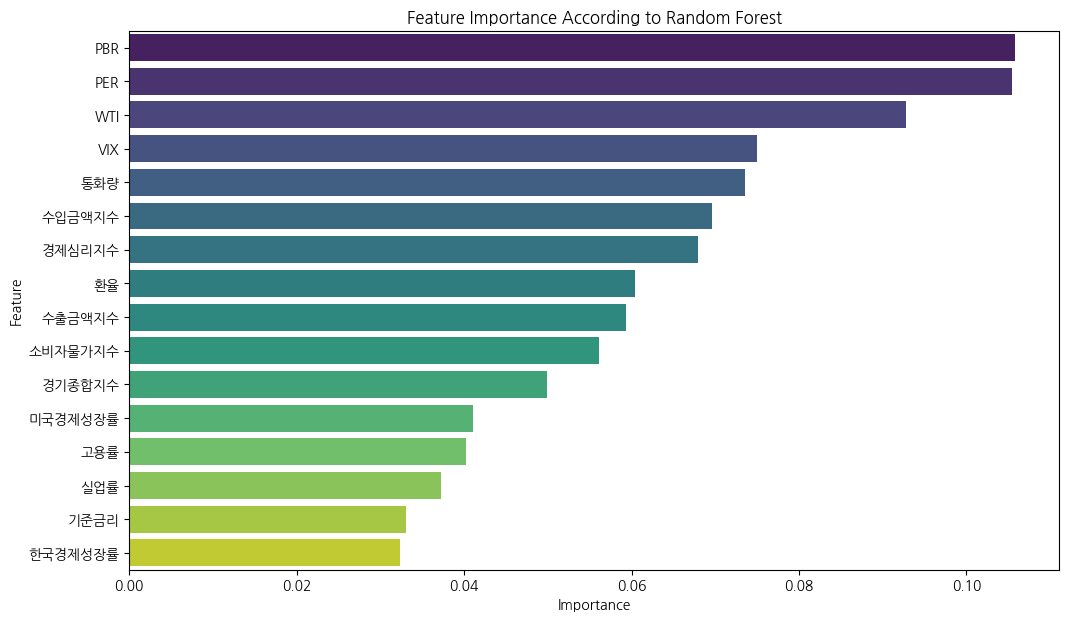

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

plt.rc('font', family='NanumGothic')
# mpl.rcParams['axes.unicode_minus'] = False

# 피처 중요도 추출
feature_importances = best_clf.feature_importances_

# 데이터프레임 생성 및 시각화
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(x='Importance', y='Feature', data=features_df, palette='viridis')
plt.title('Feature Importance According to Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [11]:
# 올해 데이터로 테스트
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix
import joblib
from sklearn.preprocessing import LabelEncoder

# 데이터 불러오기 및 전처리
model_data = pd.read_csv('datasets/ks200.csv', encoding='cp949')

# Label Encoding
encoder = LabelEncoder()
model_data['forward_stage'] = encoder.fit_transform(model_data['forward_stage'])

# 날짜 처리 및 정렬
model_data['Date'] = pd.to_datetime(model_data['Date'])
model_data.set_index('Date', inplace=True)
model_data.sort_index(inplace=True)

# 데이터 분할
train_data = model_data[:'2014-12-31']
test_data = model_data['2015-01-01':'2015-12-31']

X_train = train_data.drop(columns=['forward_stage'])
y_train = train_data['forward_stage']
X_test = test_data.drop(columns=['forward_stage'])
y_test = test_data['forward_stage']

# 모델 초기화 및 하이퍼파라미터 그리드 정의
rnd_clf = RandomForestClassifier(n_estimators=100, n_jobs=1, random_state=42)
param_dist_rf = {
    'n_estimators': [50, 100, 500],
    'max_leaf_nodes': [20, 30, 40, 50],
    'max_features': [1, 2, 3],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 하이퍼파라미터 튜닝
strat_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
rnd_search = RandomizedSearchCV(rnd_clf, param_dist_rf, cv=strat_kfold, random_state=42)
rnd_search.fit(X_train, y_train)

# 최적 모델 선택 및 훈련
best_clf = rnd_search.best_estimator_
best_clf.fit(X_train, y_train)

# 모델 평가
train_score = best_clf.score(X_train, y_train)
test_score = best_clf.score(X_test, y_test)

# 10-fold cross-validation의 정확도 계산
cv_scores = cross_val_score(best_clf, X_train, y_train, cv=strat_kfold, scoring='accuracy')
cv_mean_score = cv_scores.mean()

# label encoding된 값 찾기
up = encoder.transform(['up'])[0]
neutral = encoder.transform(['neutral'])[0]
down = encoder.transform(['down'])[0]

# 혼동 행렬 확인
y_test_pred = best_clf.predict(X_test)
cm_test = confusion_matrix(y_test, y_test_pred, labels=[up, neutral, down])
y_all_pred = best_clf.predict(X_test)
cm_all = confusion_matrix(y_test, y_all_pred, labels=[up, neutral, down])

# 특성 중요도 확인
feature_importance = list(zip(X_train.columns, best_clf.feature_importances_))

# 모델 저장
joblib.dump(best_clf, "separation.pkl")

# 결과를 출력합니다.
print(f"{rnd_search.best_params_}\n")
print("<10-fold cross-validation>")
print("accuracy score mean: ", cv_mean_score)
print("accuracy scores for each fold:")
for i, score in enumerate(cv_scores, start=1):
    print(f"Fold {i}: {score}")
print("\n<AI model: machine learning done >")
print("accuracy_score of train data: ", train_score)
print("accuracy_score of test data: ", test_score)
print("\n<Confusion matrix>")
print("(of test)")
print("up", "neutral", "down")
print(cm_test)
print("(of all)")
print("up", "neutral", "down")
print(cm_all)
print("\n<Feature importance>")
sorted_feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
for name, score in sorted_feature_importance:
    print(name, ": ", score)
print("\n< AI model: save >")


{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_leaf_nodes': 50, 'max_features': 3, 'max_depth': 10}

<10-fold cross-validation>
accuracy score mean:  0.877652933832709
accuracy scores for each fold:
Fold 1: 0.8888888888888888
Fold 2: 0.9
Fold 3: 0.9111111111111111
Fold 4: 0.8555555555555555
Fold 5: 0.8444444444444444
Fold 6: 0.8444444444444444
Fold 7: 0.8888888888888888
Fold 8: 0.8222222222222222
Fold 9: 0.9333333333333333
Fold 10: 0.8876404494382022

<AI model: machine learning done >
accuracy_score of train data:  0.9388209121245829
accuracy_score of test data:  0.5578512396694215

<Confusion matrix>
(of test)
up neutral down
[[  4  30  17]
 [  0   0  60]
 [  0   0 131]]
(of all)
up neutral down
[[  4  30  17]
 [  0   0  60]
 [  0   0 131]]

<Feature importance>
per :  0.16357234505210513
pbr :  0.1280663966345509
USDKRW :  0.09033297559819455
WTI :  0.07362668027734585
1 :  0.06296371326100089
6 :  0.0629344849400948
7 :  0.059723801097081565
4 :  0.059333

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 불러오기
model_data = pd.read_csv('datasets/ks200.csv', encoding='cp949')

# 필요한 특성만 선택합니다. 'forward_stage'와 'Date'는 제외합니다.
features = model_data.drop(columns=['forward_stage', 'Date'])

# 상관관계 행렬을 구합니다.
correlation_matrix = features.corr()

# 0.7 이상의 상관관계를 가진 특성 쌍을 찾습니다.
high_corr_pairs = {}
for column in correlation_matrix.columns:
    for index in correlation_matrix.index:
        if 0.7 < abs(correlation_matrix.loc[index, column]) < 1:  # 상관관계가 0.7 이상이고 1 미만인 경우
            if (column, index) not in high_corr_pairs and (index, column) not in high_corr_pairs:  # 중복된 쌍을 방지
                high_corr_pairs[(index, column)] = correlation_matrix.loc[index, column]

high_corr_pairs


{('1', 'USDKRW'): 0.7076566109771754,
 ('4', 'USDKRW'): 0.7427009556362301,
 ('4', '1'): 0.972424321169102,
 ('9', '1'): 0.7213768621787462,
 ('5', '3'): 0.8848392125230665,
 ('9', '4'): 0.8219263559373197,
 ('11', '10'): 0.7594533209530712}

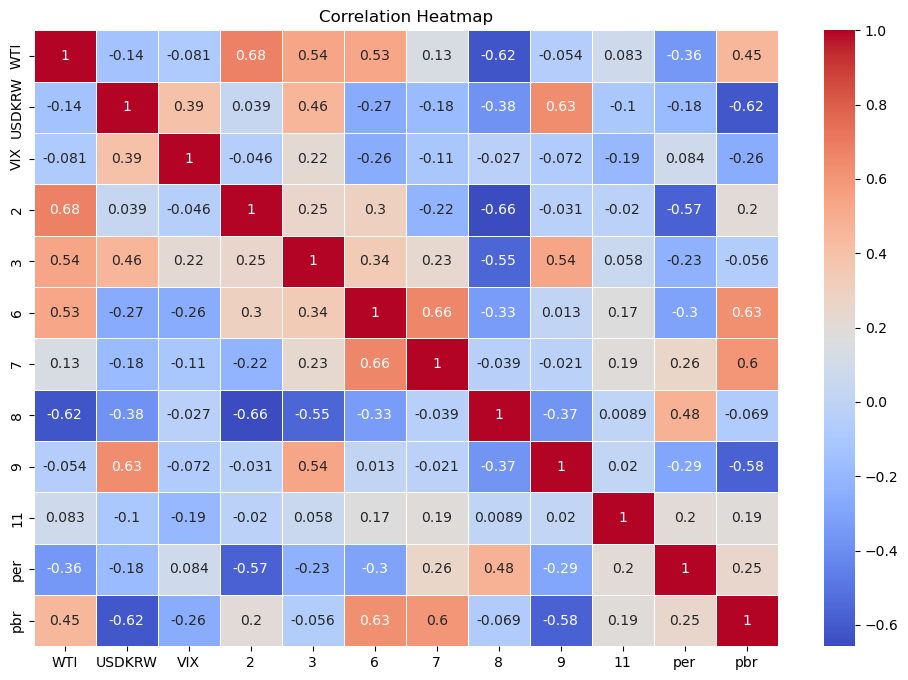

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 불러오기
model_data = pd.read_csv('1_new.csv', encoding='cp949')

# 필요한 특성만 선택합니다. 'forward_stage'와 'Date'는 제외합니다.
features = model_data.drop(columns=['forward_stage', 'Date'])

# 상관관계 행렬을 구합니다.
correlation_matrix = features.corr()

# 히트맵을 그립니다.
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()


In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 불러오기
model_data = pd.read_csv('1_new.csv', encoding='cp949')

# 필요한 특성만 선택합니다. 'forward_stage'와 'Date'는 제외합니다.
features = model_data.drop(columns=['forward_stage', 'Date'])

# 상관관계 행렬을 구합니다.
correlation_matrix = features.corr()

# 0.7 이상의 상관관계를 가진 특성 쌍을 찾습니다.
high_corr_pairs = {}
for column in correlation_matrix.columns:
    for index in correlation_matrix.index:
        if 0.7 < abs(correlation_matrix.loc[index, column]) < 1:  # 상관관계가 0.7 이상이고 1 미만인 경우
            if (column, index) not in high_corr_pairs and (index, column) not in high_corr_pairs:  # 중복된 쌍을 방지
                high_corr_pairs[(index, column)] = correlation_matrix.loc[index, column]

high_corr_pairs


{}